In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Load the dataset
file_path = "/content/drive/MyDrive/data.csv"
data = pd.read_csv(file_path, encoding='latin1')

# Inspect the data
print(data.head())
print(data.info())
print(data.describe().T)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

In [3]:
data_no_duplicates = data.copy()  # Create a copy of the data
data_no_duplicates = data.drop_duplicates()  # Drop duplicates

# Print the shape of the original and the no-duplicates DataFrame
print(data.shape)  # Correct way to access shape
print(data_no_duplicates.shape)  # Correct way to access shape

(541909, 8)
(536641, 8)


In [4]:
# Step 1: Create a copy to preserve original data
data_filled = data_no_duplicates.copy()

# Step 2: Create a mapping of StockCode to the most common Description
stockcode_to_description = (
    data_filled.groupby("StockCode")["Description"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

# Step 3: Fill missing Descriptions using StockCode mapping
data_filled["Description"] = data_filled["Description"].fillna(data_filled["StockCode"].map(stockcode_to_description))

# Step 4: If any missing values remain, fill with most common description in the dataset
if data_filled["Description"].isnull().sum() > 0:
    most_common_description = data_filled["Description"].mode()[0]
    data_filled["Description"] = data_filled["Description"].fillna(most_common_description)

# Step 5: Verify if all missing values are filled
print("Missing values in Description after filling:", data_filled["Description"].isnull().sum())  # Should be 0

# Display sample rows with filled descriptions
print(data_filled.head())
print(data_filled.isnull().sum())

Missing values in Description after filling: 0
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country     

In [5]:
# Step 1: Create a copy to preserve original data
data_imputation = data_filled.copy()

# Step 2: Fill missing CustomerID using forward and backward fill within the same InvoiceNo
data_imputation["CustomerID"] = (
    data_imputation.groupby("InvoiceNo")["CustomerID"]
    .transform(lambda x: x.ffill().bfill())
)

# Step 3: If there are still missing values, interpolate them (based on previous & next values)
data_imputation["CustomerID"] = data_imputation["CustomerID"].interpolate()

# Step 4: Convert CustomerID to integer (optional, only if there are no remaining NaNs)
if data_imputation["CustomerID"].isnull().sum() == 0:
    data_imputation["CustomerID"] = data_imputation["CustomerID"].astype(int)

# Step 5: Verify if all missing values are filled
print("Missing values in CustomerID after filling:", data_imputation["CustomerID"].isnull().sum())  # Should be 0

# Display sample rows with filled CustomerID
print(data_imputation.head())
print(data_imputation.isnull().sum())

Missing values in CustomerID after filling: 0
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55       17850  United Kingdom  
1  12/1/2010 8:26       3.39       17850  United Kingdom  
2  12/1/2010 8:26       2.75       17850  United Kingdom  
3  12/1/2010 8:26       3.39       17850  United Kingdom  
4  12/1/2010 8:26       3.39       17850  United Kingdom  
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [6]:
# Create a copy of the original DataFrame
data_no_negatives = data_imputation.copy()

# Remove rows where 'Quantity' or 'UnitPrice' are less than or equal to zero
data_no_negatives = data_no_negatives[(data_no_negatives['Quantity'] > 0) & (data_no_negatives['UnitPrice'] > 0)]

# Create a copy of the original DataFrame for the negatives
data_only_negatives = data_imputation.copy()

# Filter out rows where 'Quantity' or 'UnitPrice' are greater than zero (keep values that are 0 or less)
data_only_negatives = data_only_negatives[(data_only_negatives['Quantity'] <= 0) | (data_only_negatives['UnitPrice'] <= 0)]

# Check the first few rows of each DataFrame to confirm
print("Data without negatives (data_no_negatives):")
print(data_no_negatives.head())

print("\nData with only negatives (data_only_negatives):")
print(data_only_negatives.head())

Data without negatives (data_no_negatives):
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55       17850  United Kingdom  
1  12/1/2010 8:26       3.39       17850  United Kingdom  
2  12/1/2010 8:26       2.75       17850  United Kingdom  
3  12/1/2010 8:26       3.39       17850  United Kingdom  
4  12/1/2010 8:26       3.39       17850  United Kingdom  

Data with only negatives (data_only_negatives):
    InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          

In [7]:
# Create a copy of data_no_negatives
data_filtered = data_no_negatives.copy()

# Remove rows where 'Description' contains 'AMAZON FEE' or 'Adjust bad debt'
data_filtered = data_filtered[~data_filtered['Description'].str.contains('AMAZON FEE|Adjust bad debt', case=False, na=False)]

# Remove rows where 'Quantity' is 74215 or 80995
data_filtered = data_filtered[~data_filtered['Quantity'].isin([74215, 80995])]

# Print the first few rows to confirm the removal
print("Updated data_filtered after removing certain rows:")
print(data_filtered.head())


Updated data_filtered after removing certain rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55       17850  United Kingdom  
1  12/1/2010 8:26       3.39       17850  United Kingdom  
2  12/1/2010 8:26       2.75       17850  United Kingdom  
3  12/1/2010 8:26       3.39       17850  United Kingdom  
4  12/1/2010 8:26       3.39       17850  United Kingdom  


In [8]:
print(data_filtered.head())
print(data_filtered.isnull().sum())
print(data_filtered.describe().T)
print(data_filtered.info())
print(data_filtered.shape)
print(data_filtered.dtypes)
print(data_filtered.nunique())
print(data_filtered.columns)
print(data_filtered.duplicated().sum())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55       17850  United Kingdom  
1  12/1/2010 8:26       3.39       17850  United Kingdom  
2  12/1/2010 8:26       2.75       17850  United Kingdom  
3  12/1/2010 8:26       3.39       17850  United Kingdom  
4  12/1/2010 8:26       3.39       17850  United Kingdom  
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
               count          mean          std        min      

In [9]:
# Remove duplicates based on InvoiceNo and StockCode, keeping the first occurrence
data_relevant = data_filtered.drop_duplicates(subset=['InvoiceNo', 'StockCode'])


In [10]:
# Group by InvoiceNo and aggregate StockCode into a list for each transaction
transactions = data_relevant.groupby('InvoiceNo')['StockCode'].apply(list).reset_index()

# Show the first few transactions
print(transactions.head())

  InvoiceNo                                          StockCode
0    536365  [85123A, 71053, 84406B, 84029G, 84029E, 22752,...
1    536366                                     [22633, 22632]
2    536367  [84879, 22745, 22748, 22749, 22310, 84969, 226...
3    536368                       [22960, 22913, 22912, 22914]
4    536369                                            [21756]


In [11]:
! pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.6 MB/s eta 0:00:00


In [12]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
# Use TransactionEncoder to convert list of transactions into the required format
te = TransactionEncoder()
te_ary = te.fit(transactions['StockCode']).transform(transactions['StockCode'])

# Convert to a DataFrame
transactions_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apply the Apriori algorithm with the transformed data
min_support = 0.01  # Set your support threshold
frequent_itemsets = apriori(transactions_encoded, min_support=min_support, use_colnames=True)

# Display the frequent itemsets
print(frequent_itemsets.head())



    support   itemsets
0  0.025958    (15036)
1  0.016086  (15056BL)
2  0.022851   (15056N)
3  0.012428   (16161P)
4  0.014533    (16237)


In [13]:
from mlxtend.frequent_patterns import association_rules

# Apply the association_rules function to find strong rules
# We'll use 'confidence' as the metric and a threshold for minimum confidence (e.g., 0.7)
min_confidence = 0.7
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

# Display the rules
print(rules.head())


  antecedents consequents  antecedent support  consequent support   support  \
0     (22356)     (20724)            0.037184            0.051716  0.026159   
1     (21094)     (21080)            0.026409            0.049411  0.018542   
2     (21086)     (21094)            0.021448            0.026409  0.017539   
3     (21136)     (84879)            0.018542            0.072914  0.012979   
4     (21899)     (21900)            0.013931            0.018642  0.010023   

   confidence       lift  representativity  leverage  conviction  \
0    0.703504  13.603123               1.0  0.024236    3.198302   
1    0.702087  14.209079               1.0  0.017237    3.190830   
2    0.817757  30.964594               1.0  0.016973    5.342266   
3    0.700000   9.600344               1.0  0.011627    3.090286   
4    0.719424  38.591707               1.0  0.009763    3.497661   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.962268  0.416933   0.687334    0.604659  
1       0.95

In [17]:
print(rules[1:100])

        antecedents consequents  antecedent support  consequent support  \
1           (21094)     (21080)            0.026409            0.049411   
2           (21086)     (21094)            0.021448            0.026409   
3           (21136)     (84879)            0.018542            0.072914   
4           (21899)     (21900)            0.013931            0.018642   
5           (22617)     (22138)            0.023252            0.046805   
..              ...         ...                 ...                 ...   
95   (20719, 22356)     (20724)            0.019795            0.051716   
96   (20719, 23204)     (20724)            0.014533            0.051716   
97  (20719, 85099B)     (20724)            0.014934            0.051716   
98   (21212, 20719)     (22355)            0.013931            0.044199   
99   (21212, 22355)     (20719)            0.013681            0.041744   

     support  confidence       lift  representativity  leverage  conviction  \
1   0.018542    0.70

In [18]:
filtered_rules = rules[rules['lift'] > 10]
print(filtered_rules.head(10))


   antecedents consequents  antecedent support  consequent support   support  \
0      (22356)     (20724)            0.037184            0.051716  0.026159   
1      (21094)     (21080)            0.026409            0.049411  0.018542   
2      (21086)     (21094)            0.021448            0.026409  0.017539   
4      (21899)     (21900)            0.013931            0.018642  0.010023   
5      (22617)     (22138)            0.023252            0.046805  0.016738   
6      (22577)     (22578)            0.026961            0.025658  0.019444   
7      (22578)     (22577)            0.025658            0.026961  0.019444   
8      (22579)     (22577)            0.016938            0.026961  0.012478   
9      (22579)     (22578)            0.016938            0.025658  0.014082   
10     (22698)     (22697)            0.038336            0.050764  0.031671   

    confidence       lift  representativity  leverage  conviction  \
0     0.703504  13.603123               1.0  0.024

In [19]:
strong_rules = rules[(rules['lift'] > 10) & (rules['confidence'] > 0.7)]
print(strong_rules.head())


  antecedents consequents  antecedent support  consequent support   support  \
0     (22356)     (20724)            0.037184            0.051716  0.026159   
1     (21094)     (21080)            0.026409            0.049411  0.018542   
2     (21086)     (21094)            0.021448            0.026409  0.017539   
4     (21899)     (21900)            0.013931            0.018642  0.010023   
5     (22617)     (22138)            0.023252            0.046805  0.016738   

   confidence       lift  representativity  leverage  conviction  \
0    0.703504  13.603123               1.0  0.024236    3.198302   
1    0.702087  14.209079               1.0  0.017237    3.190830   
2    0.817757  30.964594               1.0  0.016973    5.342266   
4    0.719424  38.591707               1.0  0.009763    3.497661   
5    0.719828  15.379186               1.0  0.015649    3.402172   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.962268  0.416933   0.687334    0.604659  
1       0.95

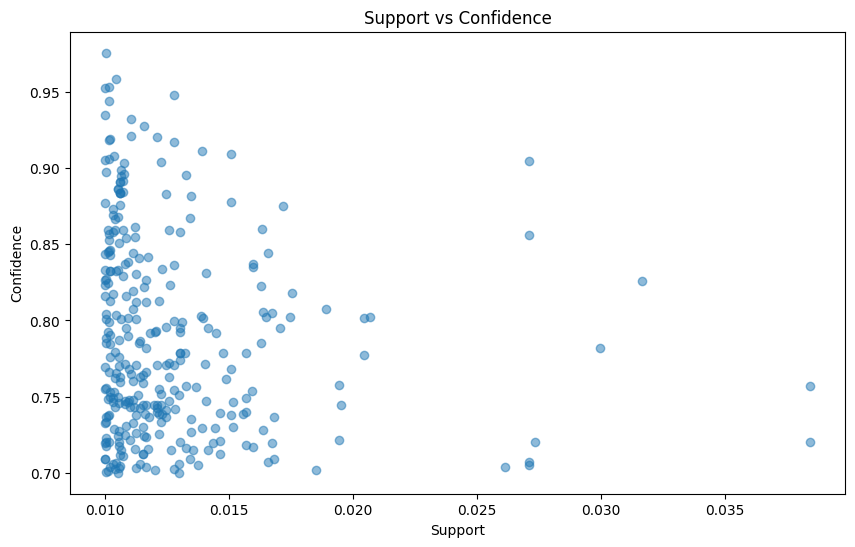

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()


In [21]:
top_10_rules = strong_rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]).head(10)
print(top_10_rules)


        antecedents     consequents  antecedent support  consequent support  \
226  (22917, 22918)         (22916)            0.010774            0.011877   
229         (22916)  (22917, 22918)            0.011877            0.010774   
227  (22916, 22918)         (22917)            0.010674            0.012027   
228         (22917)  (22916, 22918)            0.012027            0.010674   
233  (22916, 22920)         (22917)            0.010524            0.012027   
234         (22917)  (22916, 22920)            0.012027            0.010524   
235         (22916)  (22917, 22920)            0.011877            0.010724   
232  (22917, 22920)         (22916)            0.010724            0.011877   
19          (22917)         (22916)            0.012027            0.011877   
20          (22916)         (22917)            0.011877            0.012027   

      support  confidence       lift  representativity  leverage  conviction  \
226  0.010173    0.944186  79.498872              

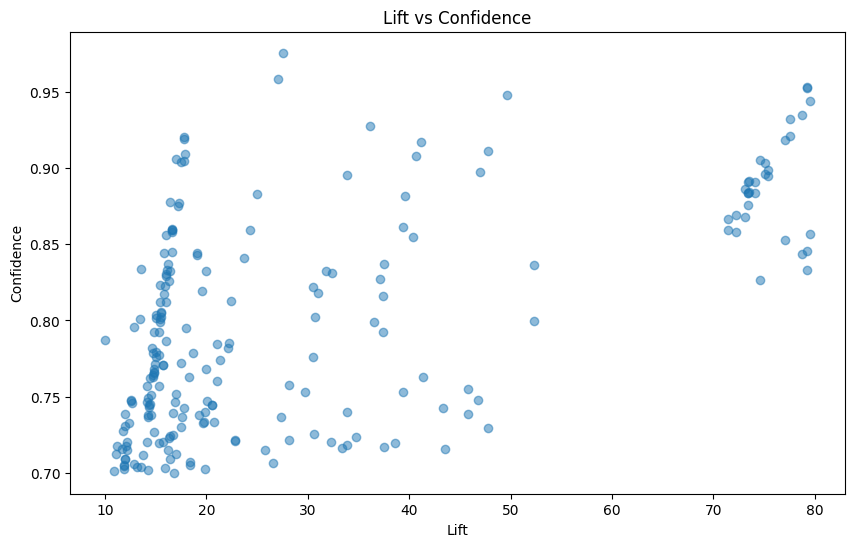

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(strong_rules['lift'], strong_rules['confidence'], alpha=0.5)
plt.title('Lift vs Confidence')
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.show()


In [23]:
high_quality_rules = strong_rules[(strong_rules['lift'] > 70) & (strong_rules['confidence'] > 0.8)]
print(high_quality_rules)


        antecedents     consequents  antecedent support  consequent support  \
19          (22917)         (22916)            0.012027            0.011877   
20          (22916)         (22917)            0.011877            0.012027   
21          (22916)         (22918)            0.011877            0.011927   
22          (22918)         (22916)            0.011927            0.011877   
23          (22919)         (22916)            0.012027            0.011877   
24          (22916)         (22919)            0.011877            0.012027   
25          (22916)         (22920)            0.011877            0.012127   
26          (22920)         (22916)            0.012127            0.011877   
27          (22917)         (22918)            0.012027            0.011927   
28          (22918)         (22917)            0.011927            0.012027   
29          (22919)         (22917)            0.012027            0.012027   
30          (22917)         (22919)            0.012

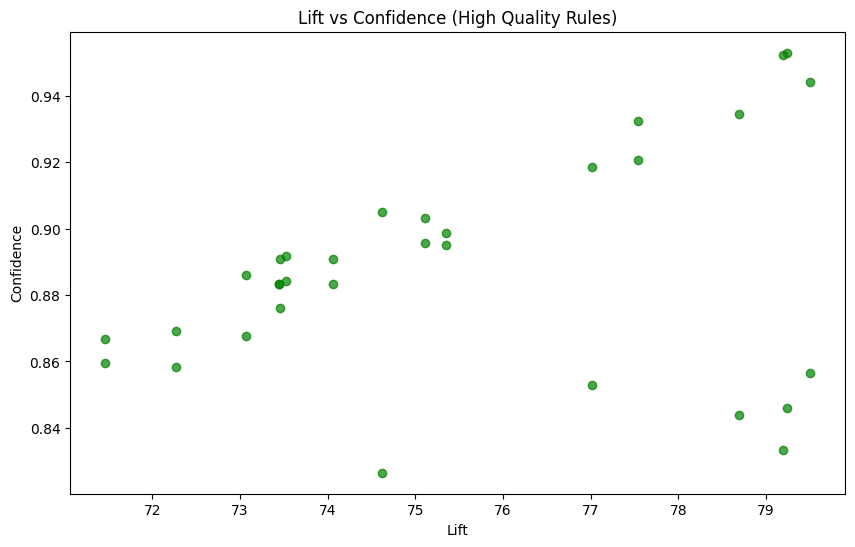

In [24]:
high_lift_confidence = strong_rules[(strong_rules['lift'] > 70) & (strong_rules['confidence'] > 0.8)]
plt.figure(figsize=(10, 6))
plt.scatter(high_lift_confidence['lift'], high_lift_confidence['confidence'], alpha=0.7, color='green')
plt.title('Lift vs Confidence (High Quality Rules)')
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.show()


In [25]:
outliers = strong_rules[(strong_rules['lift'] > 70) & (strong_rules['confidence'] < 0.7)]
print(outliers)


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


In [26]:
# Relax the filter a bit
high_quality_rules = strong_rules[(strong_rules['lift'] > 70) & (strong_rules['confidence'] > 0.75)]
print(high_quality_rules)


        antecedents     consequents  antecedent support  consequent support  \
19          (22917)         (22916)            0.012027            0.011877   
20          (22916)         (22917)            0.011877            0.012027   
21          (22916)         (22918)            0.011877            0.011927   
22          (22918)         (22916)            0.011927            0.011877   
23          (22919)         (22916)            0.012027            0.011877   
24          (22916)         (22919)            0.011877            0.012027   
25          (22916)         (22920)            0.011877            0.012127   
26          (22920)         (22916)            0.012127            0.011877   
27          (22917)         (22918)            0.012027            0.011927   
28          (22918)         (22917)            0.011927            0.012027   
29          (22919)         (22917)            0.012027            0.012027   
30          (22917)         (22919)            0.012

In [27]:
print(strong_rules[['lift', 'confidence']].describe())


             lift  confidence
count  218.000000  218.000000
mean    29.369032    0.796520
std     21.353530    0.070828
min     10.038875    0.700000
25%     15.310611    0.736725
50%     17.951293    0.781789
75%     37.319104    0.854457
max     79.498872    0.975728


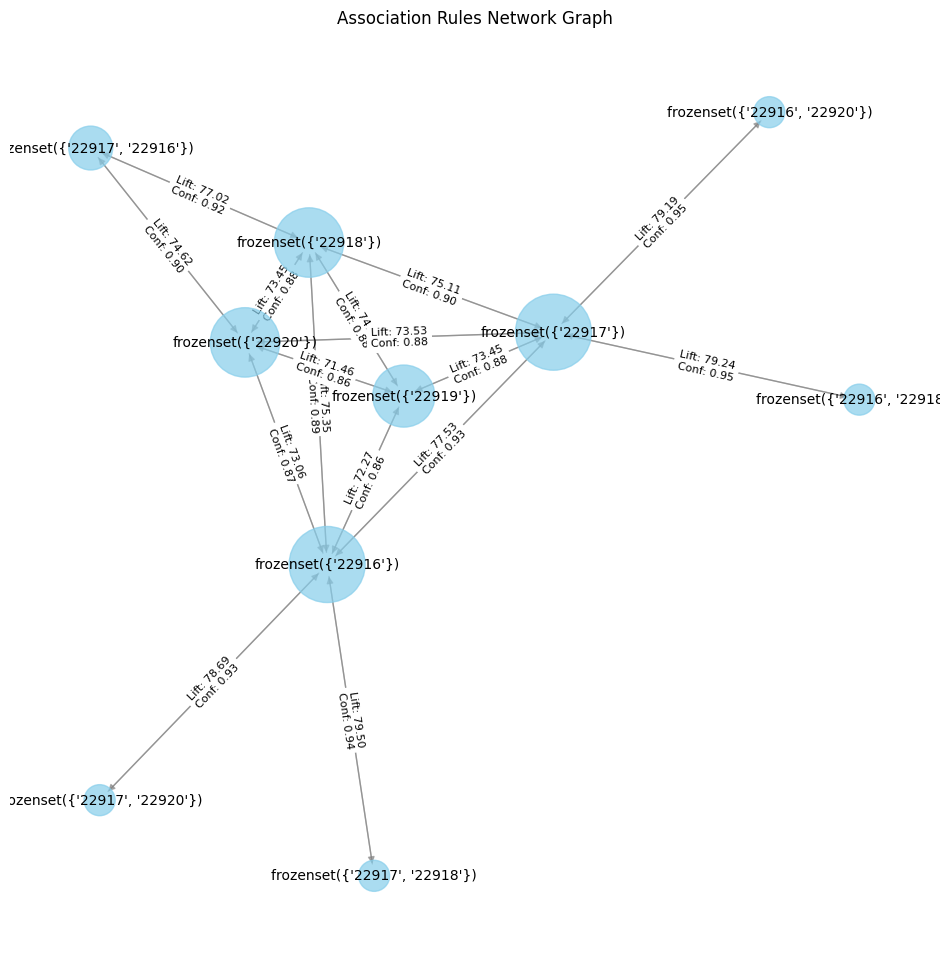

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes and edges based on the high_quality_rules DataFrame
for index, row in high_quality_rules.iterrows():
    antecedents = row['antecedents']
    consequents = row['consequents']
    lift = row['lift']
    confidence = row['confidence']

    # Add an edge for each rule, with 'lift' as the weight of the edge
    G.add_edge(antecedents, consequents, weight=lift, confidence=confidence)

# Generate a layout for the graph
pos = nx.spring_layout(G, k=0.5, iterations=20)

# Draw the graph with edge weights (lifts) as labels
plt.figure(figsize=(12, 12))

# Node sizes based on degree (number of connections)
node_size = [len(list(G.neighbors(node))) * 500 for node in G.nodes]

# Draw the nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color="skyblue", alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.6, edge_color="gray", width=1)

# Draw the labels for nodes and edges (showing lift and confidence)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")
edge_labels = {(antecedent, consequent): f"Lift: {data['weight']:.2f}\nConf: {data['confidence']:.2f}"
               for antecedent, consequent, data in G.edges(data=True)}

# Display edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Display the graph
plt.title("Association Rules Network Graph")
plt.axis('off')  # Disable axis for better visualization
plt.show()


In [29]:
import joblib

# Define the path where the model will be saved
model_save_path = '/content/drive/My Drive/ECommerce Analysis/EcommerceMBaApriori.pkl'

# Save the model (high_quality_rules in this case)
joblib.dump(high_quality_rules, model_save_path)

print(f"Model saved successfully at {model_save_path}")


Model saved successfully at /content/drive/My Drive/ECommerce Analysis/EcommerceMBaApriori.pkl


In [30]:
from mlxtend.frequent_patterns import association_rules

# Assuming you already have `frequent_itemsets` from Apriori
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Show the rules
print(rules.head())


  antecedents consequents  antecedent support  consequent support   support  \
0     (20677)     (20675)            0.016688            0.016136  0.010423   
1     (20675)     (20677)            0.016136            0.016688  0.010423   
2     (20685)    (85099B)            0.034878            0.104686  0.010373   
3    (85099B)     (20685)            0.104686            0.034878  0.010373   
4     (20712)     (20711)            0.043247            0.026159  0.014483   

   confidence       lift  representativity  leverage  conviction  \
0    0.624625  38.709268               1.0  0.010154    2.621013   
1    0.645963  38.709268               1.0  0.010154    2.777426   
2    0.297414   2.841021               1.0  0.006722    1.274313   
3    0.099090   2.841021               1.0  0.006722    1.071275   
4    0.334878  12.801719               1.0  0.013351    1.464155   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.990699  0.465324   0.618468    0.635294  
1       0.99

In [31]:
# Filter by high confidence (e.g., > 0.75) and lift (e.g., > 1.0)
high_confidence_rules = rules[(rules['confidence'] > 0.75) & (rules['lift'] > 1.0)]

# Show the filtered rules
print(high_confidence_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


     antecedents consequents   support  confidence       lift
481      (21086)     (21094)  0.017539    0.817757  30.964594
1321     (22578)     (22577)  0.019444    0.757812  28.108083
1324     (22579)     (22578)  0.014082    0.831361  32.401968
1381     (22698)     (22697)  0.031671    0.826144  16.274136
1383     (22697)     (22699)  0.038436    0.757157  14.186917


In [32]:
print(high_confidence_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].nunique())

antecedents    153
consequents     42
support         80
confidence     184
lift           178
dtype: int64


In [33]:
print(high_confidence_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].count())

antecedents    191
consequents    191
support        191
confidence     191
lift           191
dtype: int64


In [37]:
def recommend_products(product_id, rules, top_n=5):
    """
    Recommends products based on the purchased product_id.

    Parameters:
    - product_id: The ID of the product the customer has purchased.
    - rules: The dataframe of association rules generated.
    - top_n: The number of recommendations to return.

    Returns:
    - recommended_products: List of top N recommended products (human-readable).
    """
    # Filter the rules where the product is in the antecedents (frozenset)
    filtered_rules = rules[rules['antecedents'].apply(lambda x: product_id in x)]

    # Sort by lift (you can change it to confidence or support)
    sorted_rules = filtered_rules.sort_values(by='lift', ascending=False)

    # Get the top N recommended products (from consequents)
    top_recommendations = sorted_rules.head(top_n)

    # Convert frozensets to readable product IDs
    recommended_products = []
    for consequents in top_recommendations['consequents']:
        recommended_products.extend(list(consequents))

    # Remove duplicates (if any) and return the final list
    return list(set(recommended_products))

# Example: Recommend products for a customer who bought product '22918'
recommended_products = recommend_products('22918', high_confidence_rules, top_n=5)

# Print the recommendations
print("Recommended products for '22918':")
for i, product_id in enumerate(recommended_products, 1):
    print(f"{i}. Product ID: {product_id}")


Recommended products for '22918':
1. Product ID: 22917
2. Product ID: 22916


In [38]:
import joblib

# Define the path where the model will be saved
model_save_path = '/content/drive/My Drive/ECommerce Analysis/EcommerceAprioriRecommendationSystem.pkl'

# Save the model (high_confidence_rules in this case)
joblib.dump(high_confidence_rules, model_save_path)

print(f"Model saved successfully at {model_save_path}")


Model saved successfully at /content/drive/My Drive/ECommerce Analysis/EcommerceAprioriRecommendationSystem.pkl
